In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/stats207

/content/drive/My Drive/Colab Notebooks/stats207


In [3]:
import numpy as np 
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

cites:
- GRU 
  - https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b
  - https://discuss.pytorch.org/t/correctly-feeding-lstm-with-minibatch-time-sequence-data/52101/10
  - https://blog.floydhub.com/gru-with-pytorch/

- CNN-LSTM 
  - https://pseudo-lab.github.io/Tutorial-Book-en/chapters/en/time-series/Ch5-CNN-LSTM.html
  - https://github.com/pranoyr/cnn-lstm/blob/master/models/cnnlstm.py
  - 

# Data Pre-Processing

In [4]:
aqi_weekly = pd.read_csv('aqi_weekly_cleaned.csv')
aqi_weekly.head()

,week,aqi,co,ozone,pm25,no2
0,2012-01-01,75.000000,16.428571,18.857143,75.000000,36.571429
1,2012-01-08,81.714286,17.714286,20.428571,81.714286,44.571429
2,2012-01-15,48.714286,11.428571,28.714286,48.142857,31.857143
3,2012-01-22,40.857143,7.714286,23.714286,39.428571,26.428571
4,2012-01-29,55.285714,8.857143,23.857143,55.285714,33.142857


In [5]:
# Split Train and Test 
train = aqi_weekly.iloc[0:418, 1:].values
test = aqi_weekly.iloc[418:, 1:].values

print(train.shape)
print(test.shape)

(418, 5)
(104, 5)


In [6]:
train[0]

array([75.        , 16.42857143, 18.85714286, 75.        , 36.57142857])

In [7]:
# Normalize Input 
# scaler = MinMaxScaler()
scaler = StandardScaler() 

train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

In [8]:
train[0]

array([ 1.94961646,  2.45552678, -1.60596094,  2.22861216,  1.50340785])

In [9]:
test.shape

(104, 5)

# Dataset

In [10]:
timesteps = 5
n_cols = 5

In [11]:
def create_sequences(data, timesteps, n_cols):
  data_timesteps = np.array([[j for j in data[i:i+timesteps+1]] for i in range(0,len(data)-timesteps)])[:,:,]
  x, y = data_timesteps[:,:-1, :], data_timesteps[:,-1:, 0]

  return x, y 

In [12]:
x_train, y_train = create_sequences(train, timesteps, n_cols)

In [13]:
print(x_train[0], y_train[0])

[[ 1.94961646  2.45552678 -1.60596094  2.22861216  1.50340785]
 [ 2.43446627  2.84184711 -1.47059755  2.67280617  2.48223495]
 [ 0.05148105  0.95316994 -0.7568633   0.45183615  0.92659902]
 [-0.51589638 -0.16286657 -1.187565   -0.12467096  0.26239491]
 [ 0.5260149   0.18052928 -1.17525924  0.92438296  1.08391052]] [0.26811607]


In [14]:
print(x_train[1], y_train[1])

[[ 2.43446627  2.84184711 -1.47059755  2.67280617  2.48223495]
 [ 0.05148105  0.95316994 -0.7568633   0.45183615  0.92659902]
 [-0.51589638 -0.16286657 -1.187565   -0.12467096  0.26239491]
 [ 0.5260149   0.18052928 -1.17525924  0.92438296  1.08391052]
 [ 0.26811607  0.26637824 -0.71994601  0.60305113  1.04895241]] [-0.75316331]


In [15]:
torch.tensor(x_train).shape

torch.Size([413, 5, 5])

In [16]:
class TimeSeries(Dataset):
    def __init__(self,data, timesteps, n_features):
        # create sequences of length timesteps, including n_features for each item in the sequence 
        data_timesteps = np.array([[j for j in data[i:i+timesteps+1]] for i in range(0,len(data)-timesteps)])[:,:,]
        x, y = data_timesteps[:,:-1, :], data_timesteps[:,-1:, 0]

        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = len(x)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

# GRU 

In [17]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRU, self).__init__()

        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1]
        out = self.fc(out)
        return out

# CNN-LSTM

In [ ]:
x_train[0]

array([[0.34860558, 0.70422535, 0.10734463, 0.38649156, 0.45783133],
       [0.39541833, 0.76760563, 0.12288136, 0.43058161, 0.59277108],
       [0.16533865, 0.45774648, 0.20480226, 0.21013133, 0.37831325],
       [0.11055777, 0.27464789, 0.15536723, 0.15290807, 0.28674699],
       [0.21115538, 0.33098592, 0.15677966, 0.25703565, 0.4       ]])

In [ ]:
x_train[0].T

array([[0.34860558, 0.39541833, 0.16533865, 0.11055777, 0.21115538],
       [0.70422535, 0.76760563, 0.45774648, 0.27464789, 0.33098592],
       [0.10734463, 0.12288136, 0.20480226, 0.15536723, 0.15677966],
       [0.38649156, 0.43058161, 0.21013133, 0.15290807, 0.25703565],
       [0.45783133, 0.59277108, 0.37831325, 0.28674699, 0.4       ]])

In [ ]:
(torch.transpose(torch.tensor(x_train), dim0=1,dim1=2))[0]

tensor([[0.3486, 0.3954, 0.1653, 0.1106, 0.2112],
        [0.7042, 0.7676, 0.4577, 0.2746, 0.3310],
        [0.1073, 0.1229, 0.2048, 0.1554, 0.1568],
        [0.3865, 0.4306, 0.2101, 0.1529, 0.2570],
        [0.4578, 0.5928, 0.3783, 0.2867, 0.4000]], dtype=torch.float64)

In [ ]:
c = nn.Conv1d(in_channels=5, out_channels=5, kernel_size=2, stride=1)
c = c.double()
input = torch.transpose(torch.tensor(x_train), dim0=1,dim1=2) 
input = input.double() 
output = c(input)
output

tensor([[[-0.0726, -0.0677, -0.1491, -0.1701],
         [ 0.2500,  0.2178,  0.1440,  0.1249],
         [-0.2693, -0.1475, -0.1446, -0.1952],
         [ 0.1228, -0.0188, -0.0736,  0.0273],
         [-0.2747, -0.2331, -0.0729, -0.0206]],

        [[-0.0677, -0.1491, -0.1701, -0.1522],
         [ 0.2178,  0.1440,  0.1249,  0.1324],
         [-0.1475, -0.1446, -0.1952, -0.1718],
         [-0.0188, -0.0736,  0.0273,  0.0418],
         [-0.2331, -0.0729, -0.0206, -0.0570]],

        [[-0.1491, -0.1701, -0.1522, -0.1642],
         [ 0.1440,  0.1249,  0.1324,  0.1150],
         [-0.1446, -0.1952, -0.1718, -0.1266],
         [-0.0736,  0.0273,  0.0418, -0.0477],
         [-0.0729, -0.0206, -0.0570, -0.0323]],

        ...,

        [[-0.1444, -0.1584, -0.1602, -0.1592],
         [ 0.2158,  0.1532,  0.1358,  0.1361],
         [-0.2025, -0.1456, -0.1513, -0.1487],
         [ 0.0286, -0.0632, -0.0570, -0.0687],
         [-0.1263, -0.0863,  0.0071,  0.0308]],

        [[-0.1584, -0.1602, -0.1592, -

In [18]:
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, window, n_filters):
        super(CNNLSTM, self).__init__()

        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        self.conv1d = nn.Conv1d(in_channels=input_dim, out_channels=n_filters, kernel_size = window, stride = 1) # TODO: TUNE THIS 

        self.lstm = nn.LSTM(
            n_filters, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.transpose(x, dim0=1, dim1=2)
        out = self.conv1d(x)
        out = torch.transpose(out, dim0=1, dim1=2)
        out, _ = self.lstm(out)
        out = out[:, -1]
        out = self.fc(out)
        return out

# Train 

In [19]:
# TODO: use GPU 

In [20]:
N_FEATURES = train.shape[1]
INPUT_DIM = N_FEATURES
OUTPUT_DIM = 1

In [21]:
# Hyperparameters
TIMESTEPS = 7
LEARNING_RATE = 0.001
N_EPOCHS = 50
BATCH_SIZE = 32
DROPOUT = 0.7 
WEIGHT_DECAY = 0
HIDDEN_DIM = 128
LAYER_DIM = 2

In [22]:
# Additional CNN-LSTM Hyperparameters 
WINDOW = 6 
N_FILTERS = N_FEATURES 

In [23]:
train_ts = TimeSeries(train, TIMESTEPS, N_FEATURES)
test_ts = TimeSeries(test, TIMESTEPS, N_FEATURES)

In [24]:
train_loader = DataLoader(train_ts, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ts, shuffle=True, batch_size=BATCH_SIZE)

In [25]:
model = CNNLSTM(INPUT_DIM, HIDDEN_DIM, LAYER_DIM, OUTPUT_DIM, DROPOUT, WINDOW, N_FILTERS)

In [26]:
# model = GRU(INPUT_DIM, HIDDEN_DIM, LAYER_DIM, OUTPUT_DIM, DROPOUT) 

In [27]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

In [28]:
def train_model(model, train_loader, test_loader, criterion, optimizer, 
          num_epochs=N_EPOCHS, learning_rate=LEARNING_RATE, verbose=True):

    for epoch in range(1, num_epochs + 1):
        batch_num = 1
        for inputs, targets in train_loader:  

            # If using GPU 
            if torch.cuda.is_available():
                model = model.cuda()
                inputs = inputs.cuda()
                targets = targets.cuda()

            optimizer.zero_grad() 
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step() 

            if verbose and batch_num % 5 == 0:  # Print every 5 batches                              
                print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_num}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
            
            batch_num += 1

In [29]:
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=N_EPOCHS, learning_rate=LEARNING_RATE)

Epoch [1/50], Step [5/13], Loss: 0.6864
Epoch [1/50], Step [10/13], Loss: 0.5841
Epoch [2/50], Step [5/13], Loss: 0.8038
Epoch [2/50], Step [10/13], Loss: 3.1234
Epoch [3/50], Step [5/13], Loss: 0.6683
Epoch [3/50], Step [10/13], Loss: 0.6374
Epoch [4/50], Step [5/13], Loss: 0.7907
Epoch [4/50], Step [10/13], Loss: 0.6619
Epoch [5/50], Step [5/13], Loss: 0.6304
Epoch [5/50], Step [10/13], Loss: 0.8136
Epoch [6/50], Step [5/13], Loss: 0.7402
Epoch [6/50], Step [10/13], Loss: 0.7027
Epoch [7/50], Step [5/13], Loss: 0.7593
Epoch [7/50], Step [10/13], Loss: 2.5831
Epoch [8/50], Step [5/13], Loss: 0.6472
Epoch [8/50], Step [10/13], Loss: 0.3676
Epoch [9/50], Step [5/13], Loss: 2.4775
Epoch [9/50], Step [10/13], Loss: 0.7753
Epoch [10/50], Step [5/13], Loss: 0.6929
Epoch [10/50], Step [10/13], Loss: 3.1094
Epoch [11/50], Step [5/13], Loss: 0.6897
Epoch [11/50], Step [10/13], Loss: 0.5963
Epoch [12/50], Step [5/13], Loss: 1.0138
Epoch [12/50], Step [10/13], Loss: 0.8215
Epoch [13/50], Step [5

# Evaluation

In [30]:
def evaluate(test_loader,batch_size, n_features):
  with torch.no_grad():
      predictions = []
      values = []

      for x_test, y_test in test_loader:
        batch_size = x_test.shape[0]
        x_test = x_test.view([batch_size, -1, n_features])
        y_preds = model(x_test)
        y_preds = [ j for i in y_preds.tolist() for j in i  ]
        y_test = [ j for i in y_test.tolist() for j in i  ]
        predictions.extend(y_preds)
        values.extend(y_test)

  return predictions, values

In [31]:
y_test_preds, y_test = evaluate(test_loader, BATCH_SIZE, N_FEATURES)

In [32]:
def inverse_transform(y, n_features):
  # Scaling back the predictions
  # some hacks to make inverse_transform work 
  # create empty table with n_cols fields
  data_like = np.zeros(shape=(len(y), n_features))
  # put the predicted values in the right field
  data_like[:, 0] = y # assuming aqi values are always in first column 
  # inverse transform and then select the right field
  return scaler.inverse_transform(data_like)[:,0]

In [33]:
y_test_preds = inverse_transform(y_test_preds, N_FEATURES)
y_test = inverse_transform(y_test, N_FEATURES)

In [34]:
def calculate_metrics(pred, actual, verbose=True ):
    result_metrics = {'mae' : mean_absolute_error(pred, actual),
                      'mape' : mean_absolute_percentage_error(pred, actual),
                      'mse' : mean_squared_error(pred, actual), 
                      'rmse' : mean_squared_error(pred, actual) ** 0.5
                      }
    
    if verbose:
      print("Mean Absolute Error:       ", result_metrics["mae"])
      print("Mean Absolute Percentage Error:       ", result_metrics["mape"])
      print("Mean Squared Error:   ", result_metrics["mse"])
      print("Root Mean Squared Error:   ", result_metrics["rmse"])
      
    return result_metrics

In [35]:
metrics = calculate_metrics(y_test_preds, y_test)

Mean Absolute Error:        10.5844252700838
Mean Absolute Percentage Error:        0.20350191023900613
Mean Squared Error:    255.86242016577563
Root Mean Squared Error:    15.995700052382066


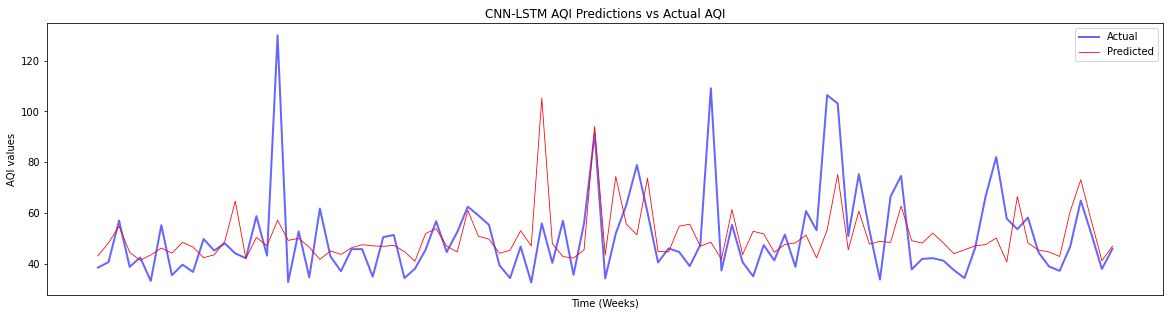

In [44]:
test_times = aqi_weekly.iloc[418+TIMESTEPS:,0]

plt.figure(figsize=(20,5))
plt.plot(test_times, y_test, color = 'blue', linewidth=2.0, alpha = 0.6)
plt.plot(test_times, y_test_preds, color = 'red', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Time (Weeks)')
plt.xticks([])
plt.ylabel('AQI values')
plt.title('CNN-LSTM AQI Predictions vs Actual AQI')
plt.show()

# Hyperparameter Tuning

## GRU

In [ ]:
N_FEATURES = train.shape[1]
INPUT_DIM = N_FEATURES
OUTPUT_DIM = 1

In [ ]:
# GRU Hyperparameters
TIMESTEPS = [1, 3, 5, 7, 10]
LEARNING_RATE = [0.001, 0.1]
BATCH_SIZE = [32, 64, 128]
N_EPOCHS = [10, 50, 100]
DROPOUT = [0, 0.1, 0.5, 0.7]
WEIGHT_DECAY = [0] # TODO: research reasonable values 
HIDDEN_DIM = [32, 128] 
LAYER_DIM = [2]

In [ ]:
# For loops to implement random search of hyperparameters 
criterion = torch.nn.MSELoss()
errors_df = pd.DataFrame()

for t in TIMESTEPS:
  train_ts = TimeSeries(train, t, N_FEATURES)
  test_ts = TimeSeries(test, t, N_FEATURES) 

  for b in BATCH_SIZE:
    train_loader = DataLoader(train_ts, shuffle=True, batch_size=b)
    test_loader = DataLoader(test_ts, shuffle=True, batch_size=b)

    for l in LEARNING_RATE: 
      for e in N_EPOCHS:
        for d in DROPOUT:
          for w in WEIGHT_DECAY:
            for h in HIDDEN_DIM:
              for lyr in LAYER_DIM: 
                model = GRU(INPUT_DIM, h, lyr, OUTPUT_DIM, d) 
                optimizer = torch.optim.Adam(model.parameters(),lr=l, weight_decay=w)
                train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=e, learning_rate=l, verbose=False)

                y_test_preds, y_test = evaluate(test_loader, b, N_FEATURES)
                y_test_preds = inverse_transform(y_test_preds, N_FEATURES)
                y_test = inverse_transform(y_test, N_FEATURES)

                params = { 'timesteps': t, 'batch_size': b, 'learning_rate': l, 'epochs':e, 'dropout': d,
                          'weight_decay' : w, 'hidden_dim': h, 'layer_dim': lyr}
                metrics = calculate_metrics(y_test_preds, y_test, verbose=False)
                out_dict = {**params,  **metrics}

                errors_df = errors_df.append(out_dict, ignore_index=True)


In [ ]:
errors_df = errors_df.sort_values(by="rmse")
errors_df.to_csv('GRU_weekly_metrics_ss.csv')
errors_df.head(30)

,timesteps,batch_size,learning_rate,epochs,dropout,weight_decay,hidden_dim,layer_dim,mae,mape,mse,rmse
205,3.0,64.0,0.001,50.0,0.5,0.0,128.0,2.0,9.397757,0.180995,189.289104,13.758238
347,5.0,64.0,0.001,50.0,0.1,0.0,128.0,2.0,9.922038,0.192793,191.122194,13.824695
255,3.0,128.0,0.001,50.0,0.7,0.0,128.0,2.0,9.198860,0.177099,192.484675,13.873885
254,3.0,128.0,0.001,50.0,0.7,0.0,32.0,2.0,9.157553,0.175586,192.975309,13.891555
251,3.0,128.0,0.001,50.0,0.1,0.0,128.0,2.0,9.633239,0.183388,193.749017,13.919376
150,3.0,32.0,0.001,10.0,0.7,0.0,32.0,2.0,9.435315,0.182044,195.451799,13.980408
263,3.0,128.0,0.001,100.0,0.7,0.0,128.0,2.0,9.415588,0.175123,196.533154,14.019028
243,3.0,128.0,0.001,10.0,0.1,0.0,128.0,2.0,9.219346,0.178662,196.978925,14.034918
145,3.0,32.0,0.001,10.0,0.0,0.0,128.0,2.0,9.430234,0.178647,197.240129,14.044220
195,3.0,64.0,0.001,10.0,0.1,0.0,128.0,2.0,9.297611,0.176134,197.488136,14.053047


## CNN-LSTM

In [ ]:
# CNN-LSTM Hyperparameters (same like GRU, except TIMESTEPS)
TIMESTEPS = [3, 5, 7]

In [ ]:
# Additional CNN-LSTM Hyperparameters: WINDOW and N_FILTERS
# for t in TIMESTEPS:
#   WINDOW = [ i for i in range(2, t)]
#   print(t)
#   print(WINDOW)

N_FILTERS = N_FEATURES 

In [ ]:
# For loops to implement random search of hyperparameters 
criterion = torch.nn.MSELoss()
errors_df = pd.DataFrame()

for t in TIMESTEPS:
  train_ts = TimeSeries(train, t, N_FEATURES)
  test_ts = TimeSeries(test, t, N_FEATURES) 
  WINDOW = [ i for i in range(2, t)]
  for b in BATCH_SIZE:
    train_loader = DataLoader(train_ts, shuffle=True, batch_size=b)
    test_loader = DataLoader(test_ts, shuffle=True, batch_size=b)

    for l in LEARNING_RATE: 
      for e in N_EPOCHS:
        for d in DROPOUT:
          for w in WEIGHT_DECAY:
            for h in HIDDEN_DIM:
              for lyr in LAYER_DIM: 
                for win in WINDOW:
                  params = { 'timesteps': t, 'batch_size': b, 'learning_rate': l, 'epochs':e, 'dropout': d,
                            'weight_decay' : w, 'hidden_dim': h, 'layer_dim': lyr, 'window': win}
                  #print(params)

                  model = CNNLSTM(INPUT_DIM, h, lyr, OUTPUT_DIM, d, win, N_FILTERS)
                  optimizer = torch.optim.Adam(model.parameters(),lr=l, weight_decay=w)
                  train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=e, learning_rate=l, verbose=False)

                  y_test_preds, y_test = evaluate(test_loader, b, N_FEATURES)
                  y_test_preds = inverse_transform(y_test_preds, N_FEATURES)
                  y_test = inverse_transform(y_test, N_FEATURES)

                  
                  metrics = calculate_metrics(y_test_preds, y_test, verbose=False)
                  out_dict = {**params,  **metrics}

                  errors_df = errors_df.append(out_dict, ignore_index=True)


In [ ]:
errors_df = errors_df.sort_values(by="rmse")
errors_df.to_csv('CNNLSTM_weekly_metrics_ss.csv')
errors_df.head(30)

,timesteps,batch_size,learning_rate,epochs,dropout,weight_decay,hidden_dim,layer_dim,window,mae,mape,mse,rmse
655,7.0,32.0,0.001,50.0,0.7,0.0,128.0,2.0,6.0,9.327061,0.172565,169.870615,13.033442
182,5.0,32.0,0.001,50.0,0.5,0.0,32.0,2.0,4.0,9.162358,0.176648,171.482715,13.095141
353,5.0,64.0,0.001,100.0,0.5,0.0,128.0,2.0,4.0,9.596681,0.188427,190.551106,13.804025
479,5.0,128.0,0.001,50.0,0.7,0.0,128.0,2.0,4.0,9.232368,0.173218,191.009529,13.820620
895,7.0,64.0,0.001,50.0,0.7,0.0,128.0,2.0,6.0,9.385820,0.177607,191.837861,13.850555
107,3.0,128.0,0.001,50.0,0.1,0.0,128.0,2.0,2.0,9.250715,0.180394,194.454750,13.944703
200,5.0,32.0,0.001,100.0,0.1,0.0,32.0,2.0,4.0,9.952477,0.193269,195.958485,13.998517
1115,7.0,128.0,0.001,50.0,0.1,0.0,128.0,2.0,6.0,9.831785,0.184329,196.015762,14.000563
332,5.0,64.0,0.001,50.0,0.7,0.0,32.0,2.0,4.0,9.483048,0.180713,196.246839,14.008813
502,5.0,128.0,0.001,100.0,0.7,0.0,128.0,2.0,3.0,9.710397,0.187756,196.623722,14.022258
